In [6]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime, date, timedelta

### Combines already downloaded air data with covid data

In [7]:
path_to_AQMD = '../AQMD data'

no2_data = [x for x in os.listdir(path_to_AQMD+'/no2') if not x.startswith('.')]
ozone_data = [x for x in os.listdir(path_to_AQMD+'/ozone') if not x.startswith('.')]
pm25_data = [x for x in os.listdir(path_to_AQMD+'/pm25') if not x.startswith('.')]

no2_counties = [x.split('.')[0][:-4] for x in no2_data]
ozone_counties = [x.split('.')[0][:-6] for x in ozone_data]
pm25_counties = [x.split('.')[0][:-5] for x in pm25_data]

counties_to_use = list(set(no2_counties) & set(ozone_counties) & set(pm25_counties))

no2_data_paths = [path_to_AQMD+f'/no2/{x}' for x in no2_data if x.split('.')[0][:-4] in counties_to_use]
ozone_data_paths = [path_to_AQMD+f'/ozone/{x}' for x in ozone_data if x.split('.')[0][:-6] in counties_to_use]
pm25_data_paths = [path_to_AQMD+f'/pm25/{x}' for x in pm25_data if x.split('.')[0][:-5] in counties_to_use]
data_paths = no2_data_paths + ozone_data_paths + pm25_data_paths

In [8]:
def get_values(file_path, datelist):
    df = pd.read_csv(file_path)
    
    df = df.iloc[list(range(31))]
    df.index = ["%02d" % int(x) for x in df['dom']]
    df = df.drop('dom', axis=1)
    cols = ["%02d" % x for x in range(1,13)]
    df = df.replace([" "],np.nan)
    df.columns = cols
    
    values = []
    for date in datelist:
        day = date[-2:]
        month = date[5:7]
        value = df.loc[day][month]
        values.append(value)
    return values

In [10]:
start_date = '2020-01-26'
end_date = '2020-12-31'
# end_date = str(date.today() - timedelta(days = 1))

data = {}

datelist = pd.date_range(start_date, end_date).tolist()
datelist = [date.to_pydatetime().strftime('%Y-%m-%d') for date in datelist]

for county in counties_to_use:
    data[county] = {}
    
for path in data_paths:
    variable = path.split('/')[2]
    county = '_'.join(path.split('/')[-1].split('.')[0].split('_')[:-1])
    data[county][variable] = get_values(path, datelist)

In [11]:
df = pd.DataFrame()
for key in data.keys():
#     print(data[key])
    data_df = pd.DataFrame(data[key])
    data_df[data_df.columns] = data_df[data_df.columns].apply(pd.to_numeric)
    data_df.insert(0, 'Date', datelist)
    data_df["Date"] = pd.to_datetime(data_df["Date"])
    data_df["County"] = key
    df = df.append(data_df)
df = df.reset_index(drop=True)
df

,Date,no2,ozone,pm25,County
0,2020-01-26,0.024,0.046,42.6,San_Bernardino
1,2020-01-27,0.035,0.041,40.4,San_Bernardino
2,2020-01-28,0.040,0.043,15.7,San_Bernardino
3,2020-01-29,0.019,0.044,11.9,San_Bernardino
4,2020-01-30,0.038,0.042,11.6,San_Bernardino
...,...,...,...,...,...
10907,2020-12-27,NaN,NaN,NaN,Marin
10908,2020-12-28,NaN,NaN,NaN,Marin
10909,2020-12-29,NaN,NaN,NaN,Marin
10910,2020-12-30,NaN,NaN,NaN,Marin


<AxesSubplot:>

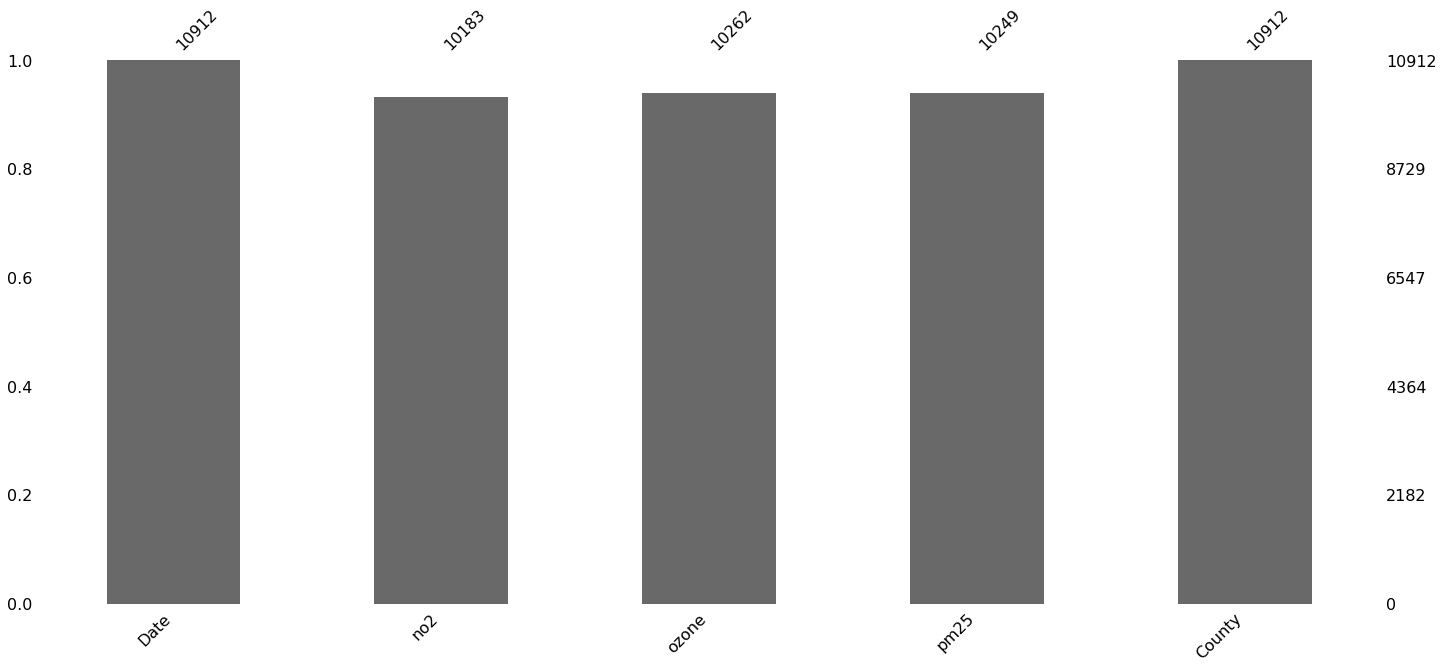

In [12]:
msno.bar(df)

In [13]:
nan_df = df[df.isna().any(axis=1)]
nan_df

,Date,no2,ozone,pm25,County
314,2020-12-05,NaN,0.045,20.7,San_Bernardino
317,2020-12-08,NaN,NaN,NaN,San_Bernardino
318,2020-12-09,NaN,NaN,NaN,San_Bernardino
319,2020-12-10,NaN,NaN,NaN,San_Bernardino
320,2020-12-11,NaN,NaN,NaN,San_Bernardino
...,...,...,...,...,...
10907,2020-12-27,NaN,NaN,NaN,Marin
10908,2020-12-28,NaN,NaN,NaN,Marin
10909,2020-12-29,NaN,NaN,NaN,Marin
10910,2020-12-30,NaN,NaN,NaN,Marin


In [14]:
for county in nan_df.County:
    county_df = df[df['County'] == county]
    for var in ['no2', 'ozone', 'pm25']:
        mean = county_df[var].mean() 
        values = {var: mean}
        df.loc[df.County==county, var] = df.loc[df.County==county, var].fillna(df[df['County'] == county][var].median())


<AxesSubplot:>

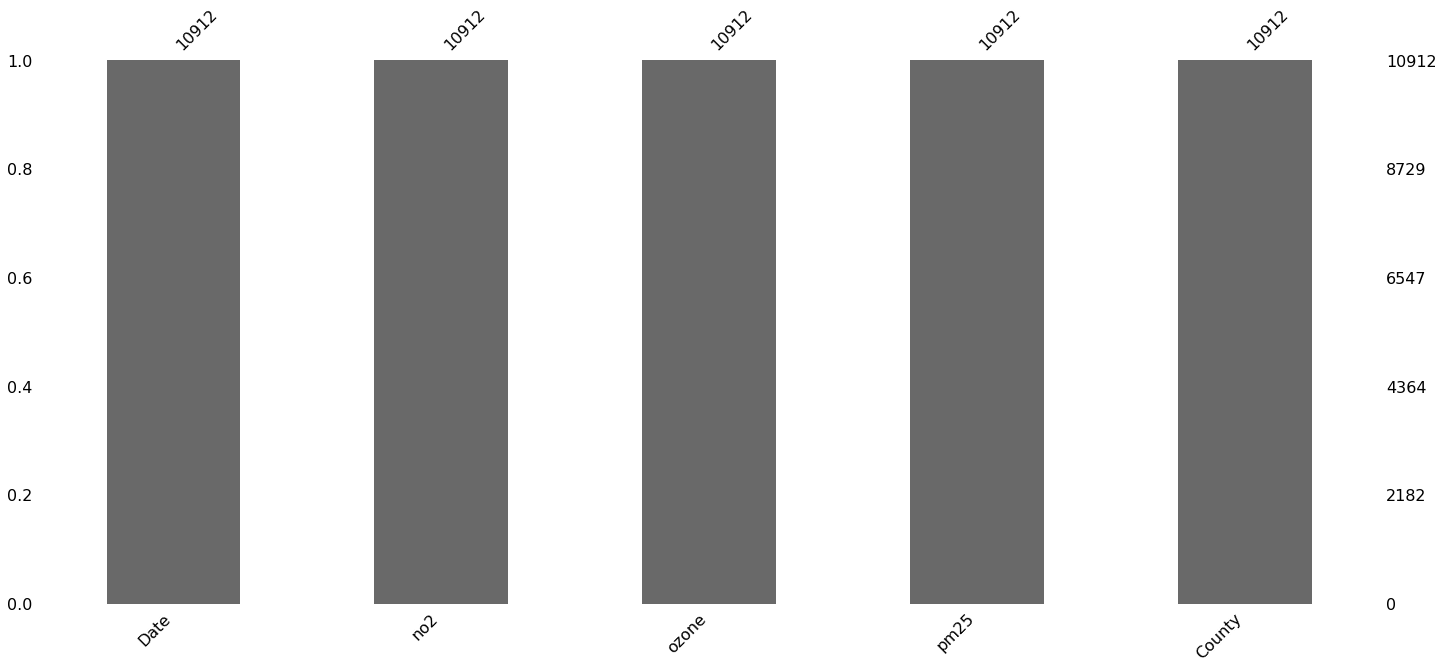

In [15]:
msno.bar(df)

In [16]:
df.head()

,Date,no2,ozone,pm25,County
0,2020-01-26,0.024,0.046,42.6,San_Bernardino
1,2020-01-27,0.035,0.041,40.4,San_Bernardino
2,2020-01-28,0.040,0.043,15.7,San_Bernardino
3,2020-01-29,0.019,0.044,11.9,San_Bernardino
4,2020-01-30,0.038,0.042,11.6,San_Bernardino


In [17]:
df_sorted = df.sort_values(['County', 'Date'], ascending=[True, True])
df_sorted

,Date,no2,ozone,pm25,County
4774,2020-01-26,0.015,0.034,7.3,Alameda
4775,2020-01-27,0.024,0.032,9.9,Alameda
4776,2020-01-28,0.025,0.033,9.7,Alameda
4777,2020-01-29,0.022,0.024,11.8,Alameda
4778,2020-01-30,0.022,0.021,10.2,Alameda
...,...,...,...,...,...
4769,2020-12-27,0.004,0.028,8.6,Yolo
4770,2020-12-28,0.004,0.028,8.6,Yolo
4771,2020-12-29,0.004,0.028,8.6,Yolo
4772,2020-12-30,0.004,0.028,8.6,Yolo


In [18]:
target_df = pd.read_csv('https://raw.githubusercontent.com/datadesk/california-coronavirus-data/master/latimes-county-totals.csv')
target_df = target_df[['date', 'county', 'new_deaths', 'new_confirmed_cases']]
target_df = target_df[target_df['date'] < '2021-01-01']
target_df

,date,county,new_deaths,new_confirmed_cases
2204,2020-12-31,Alameda,32.0,1394.0
2205,2020-12-31,Alpine,0.0,0.0
2206,2020-12-31,Amador,0.0,13.0
2207,2020-12-31,Butte,0.0,121.0
2208,2020-12-31,Calaveras,0.0,0.0
...,...,...,...,...
19341,2020-01-26,Solano,NaN,NaN
19342,2020-01-26,Sonoma,NaN,NaN
19343,2020-01-26,Stanislaus,NaN,NaN
19344,2020-01-26,Ventura,NaN,NaN


In [20]:
target_counties = [c.replace('_', ' ') for c in counties_to_use]
target_df = target_df[target_df['county'].isin(target_counties)]
target_df

,date,county,new_deaths,new_confirmed_cases
2204,2020-12-31,Alameda,32.0,1394.0
2207,2020-12-31,Butte,0.0,121.0
2210,2020-12-31,Contra Costa,4.0,961.0
2213,2020-12-31,Fresno,0.0,251.0
2216,2020-12-31,Imperial,6.0,91.0
...,...,...,...,...
19341,2020-01-26,Solano,NaN,NaN
19342,2020-01-26,Sonoma,NaN,NaN
19343,2020-01-26,Stanislaus,NaN,NaN
19344,2020-01-26,Ventura,NaN,NaN


In [22]:
deaths_df = pd.DataFrame()
idx = pd.date_range(start_date, end_date)

for county in set(target_df.county):
    county_s = target_df[target_df.county == county]
    county_s.index = pd.to_datetime(county_s.date)
    county_s = county_s.reindex(idx)
    county_s['new_deaths'] = county_s['new_deaths'].fillna(0)
    county_s['county'] = county_s['county'].fillna(county)
    county_s['date'] = county_s.index
    county_s = county_s.reset_index(drop=True)
    deaths_df = deaths_df.append(county_s)
deaths_df.columns = ['Date', 'County', 'new_deaths', 'new_cases']
deaths_df = deaths_df.sort_values(['County', 'Date'], ascending=[True, True])
deaths_df = deaths_df.reset_index(drop=True)

deaths_df

,Date,County,new_deaths,new_cases
0,2020-01-26,Alameda,0.0,NaN
1,2020-01-27,Alameda,0.0,NaN
2,2020-01-28,Alameda,0.0,NaN
3,2020-01-29,Alameda,0.0,NaN
4,2020-01-30,Alameda,0.0,NaN
...,...,...,...,...
10907,2020-12-27,Yolo,0.0,189.0
10908,2020-12-28,Yolo,0.0,17.0
10909,2020-12-29,Yolo,0.0,145.0
10910,2020-12-30,Yolo,0.0,142.0


In [23]:
df_sorted = df_sorted.reset_index(drop=True)
df_sorted

,Date,no2,ozone,pm25,County
0,2020-01-26,0.015,0.034,7.3,Alameda
1,2020-01-27,0.024,0.032,9.9,Alameda
2,2020-01-28,0.025,0.033,9.7,Alameda
3,2020-01-29,0.022,0.024,11.8,Alameda
4,2020-01-30,0.022,0.021,10.2,Alameda
...,...,...,...,...,...
10907,2020-12-27,0.004,0.028,8.6,Yolo
10908,2020-12-28,0.004,0.028,8.6,Yolo
10909,2020-12-29,0.004,0.028,8.6,Yolo
10910,2020-12-30,0.004,0.028,8.6,Yolo


In [26]:
df_sorted['new_deaths'] = deaths_df['new_deaths'].astype(float)
df_sorted['new_cases'] = deaths_df['new_cases'].astype(float)
df_sorted['new_cases'] = df_sorted['new_cases'].replace(np.nan, 0)
df_sorted

,Date,no2,ozone,pm25,County,new_deaths,new_cases
0,2020-01-26,0.015,0.034,7.3,Alameda,0.0,0.0
1,2020-01-27,0.024,0.032,9.9,Alameda,0.0,0.0
2,2020-01-28,0.025,0.033,9.7,Alameda,0.0,0.0
3,2020-01-29,0.022,0.024,11.8,Alameda,0.0,0.0
4,2020-01-30,0.022,0.021,10.2,Alameda,0.0,0.0
...,...,...,...,...,...,...,...
10907,2020-12-27,0.004,0.028,8.6,Yolo,0.0,189.0
10908,2020-12-28,0.004,0.028,8.6,Yolo,0.0,17.0
10909,2020-12-29,0.004,0.028,8.6,Yolo,0.0,145.0
10910,2020-12-30,0.004,0.028,8.6,Yolo,0.0,142.0


<AxesSubplot:>

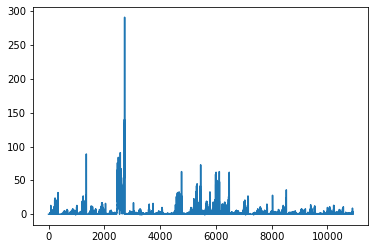

In [27]:
df_sorted['new_deaths'].plot()

In [28]:
df_sorted.to_csv('../combined_data.csv')